In [136]:
import random
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
words = open("words_alpha.txt", "r").read().splitlines()

words[1:10]

['aa', 'aaa', 'aah', 'aahed', 'aahing', 'aahs', 'aal', 'aalii', 'aaliis']

In [139]:
len(words)

370104

In [140]:
# lookup tables

characters = sorted(list(set("".join(words))))
stoi = {s : i + 1 for i, s in enumerate(characters)}
stoi["."] = 0
itos = {i : s for s, i in stoi.items()}

In [141]:
# building the dataset
random.seed(2)

def build_dataset(words):
    block_size = 3 # how many chars used to predict the next character
    X, y = [], []

    for w in words:
        context = [0] * block_size # start characters in the start
        for ch in w + '.':
            ix = stoi[ch] 
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix] # crop and append 

    X = torch.tensor(X)
    y = torch.tensor(y)
    
    return X, y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])


In [172]:
g = torch.Generator().manual_seed(5)

# originally, 2-dim embedding space, 100 neurons in hidden layer
# encoding alphabets into 10-dim space
C = torch.randn((27, 10), generator = g)

# hidden layer 1
W1 = torch.randn((30, 500), generator = g)
b1 = torch.randn(500, generator = g)

# output layer
W2 = torch.randn((500, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [143]:
# determining a good learning rate

lre = torch.linspace(0.001, 1, 1000)
lrs = 10**lre

In [187]:
# training!!!

# lri = []
# lossi = []
# stepi = []

for i in range(100000):
    # make minibatches for more efficiency
    mini_batch_size = 32
    ix = torch.randint(0, X_train.shape[0], (mini_batch_size, ))
    
    # forward pass
    emb = C[X_train[ix]] # indexing using X
    # emb = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]]) # concatenating along dimension 1
    # emb = torch.cat(torch.unbind(emb, 1), 1) # concatenating along dimension 1 (dynamic)
    # emb = emb.view(emb.shape[0], 6) # concatenating along dimension 1 (dynamic) (efficient)
    h = torch.tanh((emb.view(emb.shape[0], 30) @ W1) + b1)
    logits = ((h @ W2) + b2)
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim = True)
    # loss = -probs[torch.arange(emb.shape[0]), y].log().mean()
    # can be done using cross_entropy
    loss = F.cross_entropy(logits, y_train[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # lr = lre[i]    
    lr = 0.01
    # update
    for p in parameters:
        p.data += -lr * p.grad
        
    # lri.append(lr)
    # lossi.append(loss.item())
    # stepi.append(i)

In [188]:
# dev loss

emb = C[X_dev] # indexing using X
# emb = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]]) # concatenating along dimension 1
# emb = torch.cat(torch.unbind(emb, 1), 1) # concatenating along dimension 1 (dynamic)
# emb = emb.view(emb.shape[0], 6) # concatenating along dimension 1 (dynamic) (efficient)
h = torch.tanh((emb.view(emb.shape[0], 30) @ W1) + b1)
logits = ((h @ W2) + b2)
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim = True)
# loss = -probs[torch.arange(emb.shape[0]), y].log().mean()
# can be done using cross_entropy
loss = F.cross_entropy(logits, y_dev)
loss

tensor(2.1287, grad_fn=<NllLossBackward0>)

In [189]:
# test loss

emb = C[X_test] # indexing using X
# emb = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]]) # concatenating along dimension 1
# emb = torch.cat(torch.unbind(emb, 1), 1) # concatenating along dimension 1 (dynamic)
# emb = emb.view(emb.shape[0], 6) # concatenating along dimension 1 (dynamic) (efficient)
h = torch.tanh((emb.view(emb.shape[0], 30) @ W1) + b1)
logits = ((h @ W2) + b2)
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim = True)
# loss = -probs[torch.arange(emb.shape[0]), y].log().mean()
# can be done using cross_entropy
loss = F.cross_entropy(logits, y_test)
loss

tensor(2.1310, grad_fn=<NllLossBackward0>)

Training loss ~ Test loss means underfitting, could benefit from scaling up

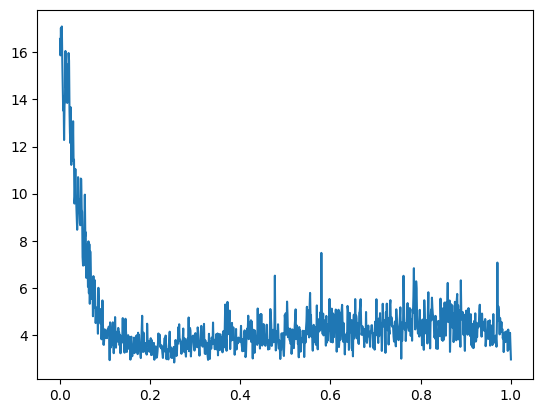

In [120]:
# lr vs loss

plt.plot(lri, lossi)

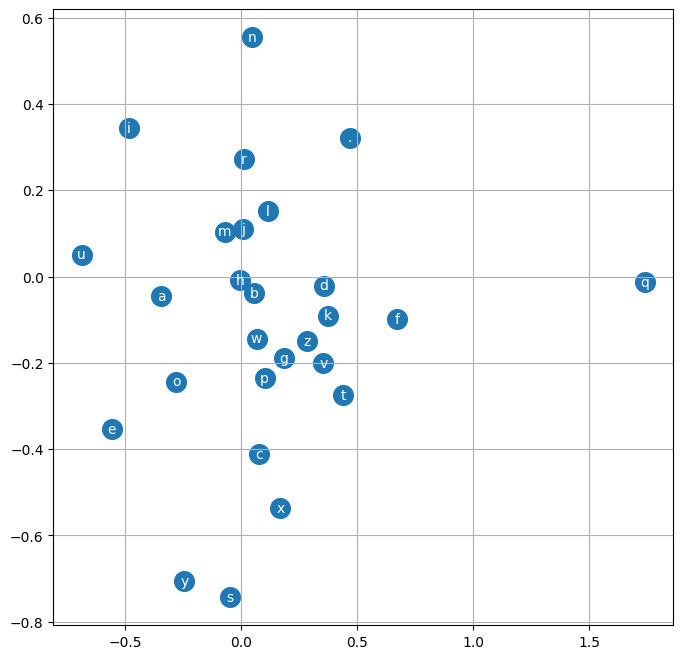

In [171]:
# 2d embeddings for each character

plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = "center", va = "center", color = "white")
    plt.grid("minor")

SO INTERESTING TO SEE VOWELS CLUSTERED TOGETHER, AND HOW EVERYTHING SORT OF MAKES SENSE